# Introduction

This is the validation notebook for the PySAL implementation of the local join count (LJC) bivariate statistic. This notebook will begin with a brief review of the bivariate LJC and a manual calculation of the values on a 'toy' dataset. We will then introduce the PySAL implementation of the `Local_Join_Count_BV` function. Output from the `Local_Join_Count_BV` function will be compared to the results from the manual calculation on the 'toy' dataset. Following the 'toy' dataset will be a comparison of the PySAL `Local_Join_Count_BV` function to the external `GeoDa` results on an external dataset. As of now, calculations of inference are not included in the function.

1. [Review of the bivariate LJC statistic](#Review)
2. [Manual calculations on a 'toy' dataset](#Toy)
3. [Implementation of Local_Join_Count_BV function](#LJC)
4. [Application of Local_Join_Count_BV function on the 'toy' dataset](#LJCToy)
5. [Application of Local_Join_Count_BV function on 'real world' datasets](#LJCRealWorld)

## Review of the bivariate LJC statistic <a name="Review"></a>

To review, global join counts focus on the total number of adjacent counts of certain values across the entire study area.  This is represented as $BB$:

$$BB = \sum_{i} \sum_j w_{ij} x_{i} x_{j}$$

Of particular interest to us are the number of local black-black (1-1) join counts. This is represented as $BB_i$: 

$$ BB_i = x_i \sum_{j} w_{ij} x_j$$

...where a count of the neighbors with an observation of $x_j=1$ for those locations where $x_i=1$. This focuses on the BB counts of a given polygon (x_i).

When considering two variables, we extend the above equation to: 

$$ BJC_i = x_i (1 - z_i) \sum_{j} w_{ij} z_j (1-x_j)$$

Note that although x and z can be reserved, the statistic is not symmetric. Results may be different whether x or z is in focus.

## Manual calculations on a 'toy' dataset <a name="Toy"></a>

We now create a small 'toy' dataset to illustrate the local join counts. This toy dataset is a 4x4 lattice grid filled with 0s and 1s for each of the x and z binary variables. Note that for a given cell, the value of the x variable comes first and the value of the z variable comes second. 

|   |   |   |   |
|---|---|---|---|
| 0,0 | 0,1 | 0,0 | 0,1 |
| 0,1 | 0,1 | 0,1 | 0,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |

The arrangement of the above grid is captured in the `x` and `z` objects below.

In [1]:
import numpy as np
import libpysal
import pandas as pd

# Create a 16x16 grid
w = libpysal.weights.lat2W(4, 4)
y_1 = np.ones(16)
# Set the first 9 of the ones to 0
y_1[0:8] = 0
# Set x equal to y_1
x = y_1
# Create another random sequence of 0 and 1
z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]

print('x', x)
print('z', z)

x [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
z [0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]


For a given cell of the above table, we are interest in the adjacent grid cells that are equal to 1. We can find these through the use of **binary weights**. 

In [2]:
# Flatten the input vector y
x = np.asarray(x).flatten()
z = np.asarray(z).flatten()
print(x)
print(z)
# ensure weights are binary transformed
w.transform = 'b'

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1]


How does PySAL identify these cells? Through an adjacency list. This creates a list object of unique focal ($i$) and neighbor ($j$) pairs. The `remove_symmetric=True` ensure that there are not duplicated (but reversed) adjacency pairs. This is a great shortcut when calculating global join counts.

In [3]:
adj_list = w.to_adjlist(remove_symmetric=True) 
print(adj_list)
print(w[0])

    focal  neighbor  weight
0       0         4     1.0
1       0         1     1.0
3       1         5     1.0
4       1         2     1.0
6       2         6     1.0
7       2         3     1.0
9       3         7     1.0
11      4         8     1.0
12      4         5     1.0
15      5         9     1.0
16      5         6     1.0
19      6        10     1.0
20      6         7     1.0
23      7        11     1.0
25      8        12     1.0
26      8         9     1.0
29      9        13     1.0
30      9        10     1.0
33     10        14     1.0
34     10        11     1.0
37     11        15     1.0
39     12        13     1.0
42     13        14     1.0
45     14        15     1.0
{4: 1.0, 1: 1.0}


From this list we can validate neighbors. For example, in our 4x4 grid, we know that the upper-left hand corner of the grid (w[0]) only touches its right and bottom neighbor(remember: we are not using a queen contiguity in this example). Thus, the first weight object will capture these relationships and they will be reflected in the adj_list table (see row 1 [0 1 1.0] and 4 [4 0 1.0]). 

**However, in the Local Join Count (LJC) we use `remove_symmetric=True`.** This allows us to identify the specific join counts for each area $i$.

In [4]:
adj_list = w.to_adjlist(remove_symmetric=False) 
print(adj_list)

    focal  neighbor  weight
0       0         4     1.0
1       0         1     1.0
2       1         0     1.0
3       1         5     1.0
4       1         2     1.0
5       2         1     1.0
6       2         6     1.0
7       2         3     1.0
8       3         2     1.0
9       3         7     1.0
10      4         0     1.0
11      4         8     1.0
12      4         5     1.0
13      5         1     1.0
14      5         4     1.0
15      5         9     1.0
16      5         6     1.0
17      6         2     1.0
18      6         5     1.0
19      6        10     1.0
20      6         7     1.0
21      7         3     1.0
22      7         6     1.0
23      7        11     1.0
24      8         4     1.0
25      8        12     1.0
26      8         9     1.0
27      9         5     1.0
28      9         8     1.0
29      9        13     1.0
30      9        10     1.0
31     10         6     1.0
32     10         9     1.0
33     10        14     1.0
34     10        11 

We now mirror the existing implementation of `Join_Counts` to create some objects that count the number of 1 value for the focal ($i$) and neighbor ($j$) cells. We do this for both the x and z variables. **Note: perhaps an area for optimization?**

In [5]:
# First, set up a series that maps the y values (input as self.y) to the weights table 
zseries_x = pd.Series(x, index=w.id_order)
zseries_z = pd.Series(z, index=w.id_order)

# Next, map the y values to the focal (i) values 
focal_x = zseries_x.loc[adj_list.focal].values
focal_z = zseries_z.loc[adj_list.focal].values

# Repeat the mapping but for the neighbor (j) values
neighbor_x = zseries_x.loc[adj_list.neighbor].values
neighbor_z = zseries_z.loc[adj_list.neighbor].values

### Case 1: No co-location

With the bivariate join count there are two situations (no co-location, and co-location). We first compute case 1 (no co-location).

In [6]:
BJC = (focal_x == 1) & (focal_z == 0) & (neighbor_x == 0) & (neighbor_z == 1)
BJC

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

Now we need to map these values to the adjacency list. By grouping by the 'ID" column of the adjacnecy list, we can get the sum of agreements where focal x and neighbor z have the same 1 value (while ensuring that the focal z and neighbor x have a value of 0). 

In [7]:
# Create a df that uses the adjacency list focal values and the BBs counts
manual_case1 = pd.DataFrame(adj_list.focal.values, BJC.astype('uint8')).reset_index()
# Temporarily rename the columns
manual_case1.columns = ['BJC', 'ID']
manual_case1 = manual_case1.groupby(by='ID').sum()
manual_case1.BJC.values

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint64)

Let's do a visual comparison to the original table (remember, x values appear first and z values appear second):

Original table


|   |   |   |   |
|---|---|---|---|
| 0,0 | 0,1 | 0,0 | 0,1 |
| 0,1 | 0,1 | 0,1 | 0,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |


Local Join Counts (bivariate)

|   |   |   |   |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 |
| 1 | 1 | 0 | 0 |
| 0 | 0 | 0 | 0 |

This makes sense give our case 1 conditions!

### Case 2: Co-location

Moving on to case 2, this is when the interest is in co-located events being surrounded by other co-located events.

This requires $x_i=z_i=1$ as well as $x_j=z_j=1$ for the neighbors. Reviewing, we formally write this as:

$$ CLC_i = x_i * z_i \sum_j w_{ij} x_j z_j $$

Given that $x_i=z_i=1$, this becomes:

$$ CLC_i = 1 * 1 \sum_j w_{ij} x_j z_j $$

Let's now implement this from the above code. The only thing we need to change is how `BJC` are calculated (now `CLC`). 

In [8]:
CLC = (focal_x == 1) & (focal_z == 1) & (neighbor_x == 1) & (neighbor_z == 1)
CLC

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True,  True, False, False, False, False, False,  True, False,
        True,  True,  True])

In [9]:
# Create a df that uses the adjacency list focal values and the BBs counts
manual_case2 = pd.DataFrame(adj_list.focal.values, CLC.astype('uint8')).reset_index()
# Temporarily rename the columns
manual_case2.columns = ['CLC', 'ID']
manual_case2 = manual_case2.groupby(by='ID').sum()
manual_case2.CLC.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2], dtype=uint64)

Let's do a visual comparison to the original table (remember, x values appear first and z values appear second):

Original table


|   |   |   |   |
|---|---|---|---|
| 0,0 | 0,1 | 0,0 | 0,1 |
| 0,1 | 0,1 | 0,1 | 0,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |


Local Join Counts (bivariate, case 2 clc)

|   |   |   |   |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 |
| 0 | 0 | 2 | 2 |
| 0 | 0 | 2 | 2 |

This makes sense give our case 2 conditions!

## Implementation of Local_Join_Count_BV function <a name="LJC"></a>

The above manual calculations are implemented in the function called `local_join_count_bv.py` (available on the [jeffcsauer/GSOC2020/scratch](https://github.com/jeffcsauer/GSOC2020/tree/master/functions) github work journal).

In [10]:
#%load_ext pycodestyle_magic

In [11]:
#%pycodestyle_off

In [12]:
import numpy as np
import pandas as pd
import warnings
from scipy import sparse
from sklearn.base import BaseEstimator
from libpysal import weights


PERMUTATIONS = 999


class Local_Join_Count_BV(BaseEstimator):

    """Univariate Local Join Count Statistic"""

    def __init__(self, connectivity=None, permutations=PERMUTATIONS):
        """
        Initialize a Local_Join_Count_BV estimator
        Arguments
        ---------
        connectivity     : scipy.sparse matrix object
                           the connectivity structure describing
                           the relationships between observed units.
                           Need not be row-standardized.
        Attributes
        ----------
        LJC              : numpy.ndarray
                           array containing the estimated
                           Bivariate Local Join Counts
        p_sim            : numpy.ndarray
                           array containing the simulated
                           p-values for each unit.
        """

        self.connectivity = connectivity
        self.permutations = permutations

    def fit(self, x, z, case="CLC", permutations=999):
        """
        Arguments
        ---------
        x                : numpy.ndarray
                           array containing binary (0/1) data
        z                : numpy.ndarray
                           array containing binary (0/1) data
        Returns
        -------
        the fitted estimator.

        Notes
        -----
        Technical details and derivations can be found in :cite:`AnselinLi2019`.

        Examples
        --------
        >>> import libpysal
        >>> w = libpysal.weights.lat2W(4, 4)
        >>> x = np.ones(16)
        >>> x[0:8] = 0
        >>> z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]
        >>> LJC_BV_C1 = Local_Join_Count_BV(connectivity=w).fit(x, z, case="BJC")
        >>> LJC_BV_C2 = Local_Join_Count_BV(connectivity=w).fit(x, z, case="CLC")
        >>> LJC_BV_C1.LJC
        >>> LJC_BV_C1.p_sim
        >>> LJC_BV_C2.LJC
        >>> LJC_BV_C2.p_sim

        Commpop data replicating GeoDa tutorial (Case 1)
        >>> import libpysal
        >>> import geopandas as gpd
        >>> commpop = gpd.read_file("https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/commpop.gpkg")
        >>> w = libpysal.weights.Queen.from_dataframe(commpop)
        >>> LJC_BV_Case1 = Local_Join_Count_BV(connectivity=w).fit(commpop['popneg'], commpop['popplus'], case='BJC')
        >>> LJC_BV_Case1.LJC
        >>> LJC_BV_Case1.p_sim

        Guerry data replicating GeoDa tutorial (Case 2)
        >>> import libpysal
        >>> import geopandas as gpd
        >>> guerry = libpysal.examples.load_example('Guerry')
        >>> guerry_ds = gpd.read_file(guerry.get_path('Guerry.shp'))
        >>> guerry_ds['infq5'] = 0
        >>> guerry_ds['donq5'] = 0
        >>> guerry_ds.loc[(guerry['Infants'] > 23574), 'infq5'] = 1
        >>> guerry_ds.loc[(guerry['Donatns'] > 10973), 'donq5'] = 1
        >>> w = libpysal.weights.Queen.from_dataframe(guerry_ds)
        >>> LJC_BV_Case2 = Local_Join_Count_BV(connectivity=w).fit(guerry_ds['infq5'], guerry_ds['donq5'], case='CLC')
        >>> LJC_BV_Case2.LJC
        >>> LJC_BV_Case2.p_sim
        """
        x = np.asarray(x).flatten()
        z = np.asarray(z).flatten()

        w = self.connectivity
        # Fill the diagonal with 0s
        w = weights.util.fill_diagonal(w, val=0)
        w.transform = 'b'

        self.x = x
        self.z = z
        self.n = len(x)
        self.w = w
        self.case = case

        self.LJC = self._statistic(x, z, w, case=case)

        if permutations:
            self._crand()
            sim = np.transpose(self.rjoins)
            above = sim >= self.LJC
            larger = above.sum(0)
            low_extreme = (self.permutations - larger) < larger
            larger[low_extreme] = self.permutations - larger[low_extreme]
            self.p_sim = (larger + 1.0) / (permutations + 1.0)
            # Set p-values for those with LJC of 0 to NaN
            self.p_sim[self.LJC == 0] = 'NaN'

        return self

    @staticmethod
    def _statistic(x, z, w, case):
        # Create adjacency list. Note that remove_symmetric=False - this is
        # different from the esda.Join_Counts() function.
        adj_list = w.to_adjlist(remove_symmetric=False)

        # First, set up a series that maps the values
        # to the weights table
        zseries_x = pd.Series(x, index=w.id_order)
        zseries_z = pd.Series(z, index=w.id_order)

        # Map the values to the focal (i) values
        focal_x = zseries_x.loc[adj_list.focal].values
        focal_z = zseries_z.loc[adj_list.focal].values

        # Map the values to the neighbor (j) values
        neighbor_x = zseries_x.loc[adj_list.neighbor].values
        neighbor_z = zseries_z.loc[adj_list.neighbor].values

        if case == "BJC":
            BJC = (focal_x == 1) & (focal_z == 0) & \
                  (neighbor_x == 0) & (neighbor_z == 1)
            adj_list_BJC = pd.DataFrame(adj_list.focal.values,
                                        BJC.astype('uint8')).reset_index()
            adj_list_BJC.columns = ['BJC', 'ID']
            adj_list_BJC = adj_list_BJC.groupby(by='ID').sum()
            return (adj_list_BJC.BJC.values)
        elif case == "CLC":
            CLC = (focal_x == 1) & (focal_z == 1) & \
                  (neighbor_x == 1) & (neighbor_z == 1)
            adj_list_CLC = pd.DataFrame(adj_list.focal.values,
                                        CLC.astype('uint8')).reset_index()
            adj_list_CLC.columns = ['CLC', 'ID']
            adj_list_CLC = adj_list_CLC.groupby(by='ID').sum()
            return (adj_list_CLC.CLC.values)
        else:
            raise NotImplementedError(f'The requested LJC method ({case}) \
            is not currently supported!')

    def _crand(self):
        """
        conditional randomization

        for observation i with ni neighbors,  the candidate set cannot include
        i (we don't want i being a neighbor of i). we have to sample without
        replacement from a set of ids that doesn't include i. numpy doesn't
        directly support sampling wo replacement and it is expensive to
        implement this. instead we omit i from the original ids,  permute the
        ids and take the first ni elements of the permuted ids as the
        neighbors to i in each randomization.

        """
        x = self.x
        z = self.z
        case = self.case

        n = len(x)
        joins = np.zeros((self.n, self.permutations))
        n_1 = self.n - 1
        prange = list(range(self.permutations))
        k = self.w.max_neighbors + 1
        nn = self.n - 1
        rids = np.array([np.random.permutation(nn)[0:k] for i in prange])
        ids = np.arange(self.w.n)
        ido = self.w.id_order
        w = [self.w.weights[ido[i]] for i in ids]
        wc = [self.w.cardinalities[ido[i]] for i in ids]

        for i in range(self.w.n):
            idsi = ids[ids != i]
            np.random.shuffle(idsi)
            tmp_x = x[idsi[rids[:, 0:wc[i]]]]
            tmp_z = z[idsi[rids[:, 0:wc[i]]]]
            if case == "BJC":
                joins[i] = x[i] * (w[i] * tmp_z).sum(1)
            elif case == "CLC":
                joins[i] = z[i] * (w[i] * tmp_z * tmp_x).sum(1)
            else:
                raise NotImplementedError(f'The requested LJC method \
                ({case}) is not currently supported!')
        self.rjoins = joins

## Application of Local_Join_Count function on the 'toy' dataset <a name="LJCToy"></a>

In [13]:
# Recreate inputs and weights (otherwise they are altered when running notebook)
w = libpysal.weights.lat2W(4, 4)
y_1 = np.ones(16)
# Set the first 9 of the ones to 0
y_1[0:8] = 0
# Set x equal to y_1
x = y_1
x = x.astype(np.int32)
# Create another random sequences of 0 and 1
z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]
# Case 1
toy_results_case1 = Local_Join_Count_BV(connectivity=w).fit(x, z, case="BJC")
print(toy_results_case1.LJC)
# Case 2
toy_results_case2 = Local_Join_Count_BV(connectivity=w).fit(x, z, case="CLC")
print(toy_results_case2.LJC)

[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 2 2 0 0 2 2]


Try passing a 'bad' case value

In [14]:
#Local_Join_Count_BV(connectivity=w).fit(x, z, case="Garbage")

Compare output of `Local_Join_Count` function to the manually-calculated `LJC` from above.

In [15]:
# Case 1
print("Comparison of toy function to manual values (Case 1)")
print(toy_results_case1.LJC == manual_case1.BJC.values)
print("----------------------------------------------------")
# Case 2
print("Comparison of toy function to manual values (Case 2)")
print(toy_results_case2.LJC == manual_case2.CLC.values)

Comparison of toy function to manual values (Case 1)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
----------------------------------------------------
Comparison of toy function to manual values (Case 2)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


All values match.

In [16]:
toy_results_case1.p_sim

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.023,
       0.007,   nan,   nan,   nan,   nan,   nan,   nan])

In [17]:
toy_results_case2.p_sim

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan, 0.168, 0.095,   nan,   nan, 0.085, 0.024])

## Application of Local_Join_Count_BV function on 'real world' datasets <a name="LJCRealWorld"></a>

Ideally, we would look to compare the output to the values from the original Anselin and Li 2019 paper. However, the example use cases in Anselin and Li 2019 do not provide full tables of LJC and associate p-values to confirm equivalency. Thus, we compare the results from the PySAL implementation of `Local_Join_Counts_BV` to the output from GeoDa using a GeoDa example dataset. Specifically, we use the [Baltimore Housing Sales dataset](https://geodacenter.github.io/data-and-lab/baltim/) and focus on the 'dwell' ($x$) and 'patio' ($z$) binary variables. 

### Comparison to GeoDa output - Case 1

For the Case 1 comparison we use the `commpop` dataset, the same dataset used in the GeoDa tutorial on [Bivariate Local Join Counts](https://geodacenter.github.io/workbook/6b_local_adv/lab6b.html#bivariate-and-multivariate-local-join-count-statistics). The variables of interest are $x$ (`popneg`) and $z$ (`popplus`). 

In [18]:
import geopandas as gpd
import libpysal

commpop = gpd.read_file("https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/commpop_geodavalues.gpkg")

w = libpysal.weights.Queen.from_dataframe(commpop)

LJC_BV_Case1 = Local_Join_Count_BV(connectivity=w).fit(commpop['popneg'], commpop['popplus'], case='BJC')


In [19]:
%timeit Local_Join_Count_BV(connectivity=w).fit(commpop['popneg'], commpop['popplus'], case='BJC')

16 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now let's compare the local join count values from `Local_Join_Count_BV` to that of GeoDa.

In [20]:
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):")
results = LJC_BV_Case1.LJC == commpop['JC_BV_C1']
print(results.value_counts())

Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):
True    77
Name: JC_BV_C1, dtype: int64


Great, a 100% match! Now let's examine how the p-values compare.

The correlation between the two sets of p-values is 0.9935067223622114


<AxesSubplot:xlabel='pysal', ylabel='geoda'>

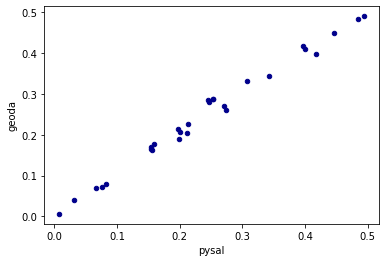

In [21]:
# Assess correlation between p-values
corrdf = pd.DataFrame(LJC_BV_Case1.p_sim, commpop.PP_VAL_BV_C1).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

Strong correlation and agreement between the two functions. No strange outlier values.

### Comparison to GeoDa output - Case 2

For Case 2 we use the Baltimore Home Sales dataset. Although this dataset is not used in the GeoDa tutorial, it is a relatively common dataset used in teaching examples. Moreover, it initiates a point of discussion between some strange disagreements between the two functions. The actual doctest of `Local_Join_Counts_BV` uses the Guerry dataset and replicates the GeoDa online tutorial.

In [22]:
balt = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/baltimore_housing.gpkg')
balt.head()

,station,price,nroom,dwell,nbath,patio,firepl,ac,bment,nstor,gar,age,citcou,lotsz,sqft,x,y,geometry
0,1.0,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,POINT (907.000 534.000)
1,2.0,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,POINT (922.000 574.000)
2,3.0,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,POINT (920.000 581.000)
3,4.0,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,POINT (923.000 578.000)
4,5.0,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,POINT (918.000 574.000)


Isolate the variable of interest.

In [23]:
x_balt = balt['dwell']
z_balt = balt['patio']

When working with points in PySAL we need to arrange them into a tree-able list of x and y points. Thus we extract the x and y columns of the baltimore dataset.

In [24]:
points = list(zip(balt['x'], balt['y']))
import libpysal
kd = libpysal.cg.KDTree(np.array(points))

We need to recreate the weights used in the GeoDa analysis. The weight scheme used was a k-nearest neighbor (knn) approach, using 5 neighbors.

In [25]:
balt_knn5 = libpysal.weights.KNN(kd, k=5) 

We can now apply our PySAL `Local_Join_Count_BV` function to the dataset. 

In [26]:
# Test results case 1
test_results_case1 = Local_Join_Count_BV(connectivity=balt_knn5).fit(x_balt, z_balt, case="BJC")
    #test_results_case1.LJC
# Test results case 2
test_results_case2 = Local_Join_Count_BV(connectivity=balt_knn5).fit(x_balt, z_balt, case="CLC")
    #test_results_case2.LJC

In [27]:
%timeit Local_Join_Count_BV(connectivity=balt_knn5).fit(x_balt, z_balt, case="BJC")

31.9 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit Local_Join_Count_BV(connectivity=balt_knn5).fit(x_balt, z_balt, case="CLC")

32.4 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now let's read in the results from GeoDa analysis.

In [29]:
# Load GeoDa analysis results
GeoDa_LJC = pd.read_csv('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/balt_knn_5_LJC_bivariate.csv')
GeoDa_LJC.head()

,station,price,nroom,dwell,nbath,patio,firepl,ac,bment,nstor,...,lotsz,sqft,x,y,JC_C1,NN_C1,PP_VAL_C1,JC_C2,NN_C2,PP_VAL_C2
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,...,5.70,11.25,907.0,534.0,0,5,NaN,0,5,NaN
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,...,279.51,28.92,922.0,574.0,4,5,0.001,4,5,0.001
2,3,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,...,70.64,30.62,920.0,581.0,5,5,0.001,5,5,0.001
3,4,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,...,174.63,26.12,923.0,578.0,5,5,0.001,5,5,0.001
4,5,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,...,107.80,22.04,918.0,574.0,3,5,0.015,3,5,0.015


Compare the PySAL LJC results to to the GeoDa LJC results. Due to the somewhat high (n=211) number of comparisons, we will tabulate the results.

In [30]:
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):")
results = test_results_case1.LJC == GeoDa_LJC['JC_C1']
print(results.value_counts())
print("--------------------------")
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 2):")
results = test_results_case2.LJC == GeoDa_LJC['JC_C2']
print(results.value_counts())

Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):
True     179
False     32
Name: JC_C1, dtype: int64
--------------------------
Comparison of GeoDa bivariate LJC to PySAL implementation (Case 2):
True    211
Name: JC_C2, dtype: int64


There is some disagreement with Case 1, but we want to focus on Case 2 implementation here.

Comparing p-values at surface level...

In [31]:
test_results_case2.p_sim[0:10]

array([  nan, 0.001, 0.001, 0.001, 0.013, 0.082, 0.001, 0.09 ,   nan,
       0.086])

In [32]:
np.array(GeoDa_LJC.PP_VAL_C2[0:10])

array([  nan, 0.001, 0.001, 0.001, 0.015, 0.098, 0.002, 0.104,   nan,
       0.095])

Differences in p-values...

In [33]:
test_results_case2.p_sim[0:10] - np.array(GeoDa_LJC.PP_VAL_C2[0:10])

array([   nan,  0.   ,  0.   ,  0.   , -0.002, -0.016, -0.001, -0.014,
          nan, -0.009])

The correlation between the two sets of p-values is 0.9979749202195467


<AxesSubplot:xlabel='pysal', ylabel='geoda'>

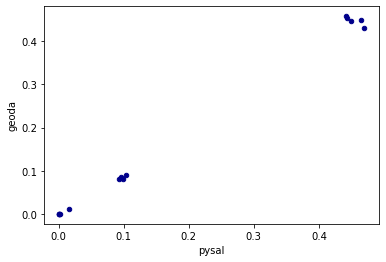

In [34]:
# Assess correlation between p-values
corrdf = pd.DataFrame(test_results_case2.p_sim, GeoDa_LJC.PP_VAL_C2).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

# Planning out some `unittest`

In [35]:
# based off: https://github.com/pysal/esda/blob/master/esda/tests/test_join_counts.py
import unittest
import numpy as np
from libpysal.weights.util import lat2W
from libpysal.common import pandas

PANDAS_EXTINCT = pandas is None

class Local_Join_Counts_Tester(unittest.TestCase):
    """Unit test for Local Join Counts (univariate)"""
    def setUp(self):
        self.w = lat2W(4, 4)
        self.x = np.ones(16)
        self.x[0:8] = 0
        self.z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]

    def test_Local_Join_Counts(self):
            """Test method"""
            np.random.seed(12345)
            ljc_bv_case1 = Local_Join_Count_BV(connectivity=self.w).fit(self.x, self.z, case="BJC")
            ljc_bv_case2 = Local_Join_Count_BV(connectivity=self.w).fit(self.x, self.z, case="CLC")
            self.assertAlmostEqual(ljc_bv_case1.LJC, [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])
            self.assertAlmostEqual(ljc_bv_case2.LJC, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2])
            

# Next steps
 
- Migrating to numba (below)


In [36]:
import numpy as np
import pandas as pd
import warnings
from scipy import sparse
from sklearn.base import BaseEstimator
from libpysal import weights
from esda.crand import (
    crand as _crand_plus,
    njit as _njit,
    _prepare_univariate,
    _prepare_bivariate
)


class Local_Join_Count_BV(BaseEstimator):

    """Univariate Local Join Count Statistic"""

    def __init__(self, connectivity=None, permutations=999, n_jobs=1, 
                 keep_simulations=True, seed=None):
        """
        Initialize a Local_Join_Count_BV estimator
        Arguments
        ---------
        connectivity     : scipy.sparse matrix object
                           the connectivity structure describing
                           the relationships between observed units.
                           Need not be row-standardized.
        permutations     : int
                           number of random permutations for calculation of pseudo
                           p_values
        n_jobs           : int
                           Number of cores to be used in the conditional randomisation. If -1,
                           all available cores are used.    
        keep_simulations : Boolean
                           (default=True)
                           If True, the entire matrix of replications under the null 
                           is stored in memory and accessible; otherwise, replications 
                           are not saved
        seed             : None/int
                           Seed to ensure reproducibility of conditional randomizations. 
                           Must be set here, and not outside of the function, since numba 
                           does not correctly interpret external seeds 
                           nor numpy.random.RandomState instances.              
                           
        """

        self.connectivity = connectivity
        self.permutations = permutations
        self.n_jobs = n_jobs
        self.keep_simulations = keep_simulations
        self.seed = seed

    def fit(self, x, y, case="CLC"):
        """
        Arguments
        ---------
        x                : numpy.ndarray
                           array containing binary (0/1) data
        y                : numpy.ndarray
                           array containing binary (0/1) data
        case             : str
                           "BJC" for bivariate local join count,
                           "CLC" for co-location local join count.
                           Details in :cite:`AnselinLi2019`.

        Returns
        -------
        the fitted estimator.

        Notes
        -----
        Technical details and derivations can be found in :cite:`AnselinLi2019`.

        Examples
        --------
        >>> import libpysal
        >>> w = libpysal.weights.lat2W(4, 4)
        >>> x = np.ones(16)
        >>> x[0:8] = 0
        >>> y = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]
        >>> LJC_BV_C1 = Local_Join_Count_BV(connectivity=w).fit(x, y, case="BJC")
        >>> LJC_BV_C2 = Local_Join_Count_BV(connectivity=w).fit(x, y, case="CLC")
        >>> LJC_BV_C1.LJC
        >>> LJC_BV_C1.p_sim
        >>> LJC_BV_C2.LJC
        >>> LJC_BV_C2.p_sim

        Commpop data replicating GeoDa tutorial (Case 1)
        >>> import libpysal
        >>> import geopandas as gpd
        >>> commpop = gpd.read_file("https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/commpop.gpkg")
        >>> w = libpysal.weights.Queen.from_dataframe(commpop)
        >>> LJC_BV_Case1 = Local_Join_Count_BV(connectivity=w).fit(commpop['popneg'], commpop['popplus'], case='BJC')
        >>> LJC_BV_Case1.LJC
        >>> LJC_BV_Case1.p_sim

        Guerry data replicating GeoDa tutorial (Case 2)
        >>> import libpysal
        >>> import geopandas as gpd
        >>> guerry = libpysal.examples.load_example('Guerry')
        >>> guerry_ds = gpd.read_file(guerry.get_path('Guerry.shp'))
        >>> guerry_ds['infq5'] = 0
        >>> guerry_ds['donq5'] = 0
        >>> guerry_ds.loc[(guerry_ds['Infants'] > 23574), 'infq5'] = 1
        >>> guerry_ds.loc[(guerry_ds['Donatns'] > 10973), 'donq5'] = 1
        >>> w = libpysal.weights.Queen.from_dataframe(guerry_ds)
        >>> LJC_BV_Case2 = Local_Join_Count_BV(connectivity=w).fit(guerry_ds['infq5'], guerry_ds['donq5'], case='CLC')
        >>> LJC_BV_Case2.LJC
        >>> LJC_BV_Case2.p_sim
        """
        # Need to ensure that the np.array() are of
        # dtype='float' for numba
        x = np.array(x, dtype='float')
        y = np.array(y, dtype='float')

        w = self.connectivity
        # Fill the diagonal with 0s
        w = weights.util.fill_diagonal(w, val=0)
        w.transform = 'b'

        self.x = x
        self.y = y
        self.n = len(x)
        self.w = w
        self.case = case
        
        keep_simulations = self.keep_simulations
        n_jobs = self.n_jobs
        seed = self.seed
        
        permutations = self.permutations

        self.LJC = self._statistic(x, y, w, case=case)

        if permutations:
            if case == "BJC":
                self.p_sim, self.rjoins = _crand_plus(
                    z=np.column_stack((x, y)),
                    w=self.w, 
                    observed=self.LJC,
                    permutations=permutations, 
                    keep=True, 
                    n_jobs=n_jobs,
                    stat_func=_ljc_bv_case1
                )
                # Set p-values for those with LJC of 0 to NaN
                self.p_sim[self.LJC == 0] = 'NaN'
            elif case == "CLC":
                self.p_sim, self.rjoins = _crand_plus(
                    z=np.column_stack((x, y)),
                    w=self.w, 
                    observed=self.LJC,
                    permutations=permutations, 
                    keep=True, 
                    n_jobs=n_jobs,
                    stat_func=_ljc_bv_case2
                )
                # Set p-values for those with LJC of 0 to NaN
                self.p_sim[self.LJC == 0] = 'NaN'
            else:
                raise NotImplementedError(f'The requested LJC method ({case}) \
                is not currently supported!')

        del (self.n, self.keep_simulations, self.n_jobs, 
             self.permutations, self.seed, self.w, self.x,
             self.y, self.connectivity, self.rjoins)
                
        return self

    @staticmethod
    def _statistic(x, y, w, case):
        # Create adjacency list. Note that remove_symmetric=False - this is
        # different from the esda.Join_Counts() function.
        adj_list = w.to_adjlist(remove_symmetric=False)

        # First, set up a series that maps the values
        # to the weights table
        zseries_x = pd.Series(x, index=w.id_order)
        zseries_y = pd.Series(y, index=w.id_order)

        # Map the values to the focal (i) values
        focal_x = zseries_x.loc[adj_list.focal].values
        focal_y = zseries_y.loc[adj_list.focal].values

        # Map the values to the neighbor (j) values
        neighbor_x = zseries_x.loc[adj_list.neighbor].values
        neighbor_y = zseries_y.loc[adj_list.neighbor].values

        if case == "BJC":
            BJC = (focal_x == 1) & (focal_y == 0) & \
                  (neighbor_x == 0) & (neighbor_y == 1)
            adj_list_BJC = pd.DataFrame(adj_list.focal.values,
                                        BJC.astype('uint8')).reset_index()
            adj_list_BJC.columns = ['BJC', 'ID']
            adj_list_BJC = adj_list_BJC.groupby(by='ID').sum()
            return (np.array(adj_list_BJC.BJC.values, dtype='float'))
        elif case == "CLC":
            CLC = (focal_x == 1) & (focal_y == 1) & \
                  (neighbor_x == 1) & (neighbor_y == 1)
            adj_list_CLC = pd.DataFrame(adj_list.focal.values,
                                        CLC.astype('uint8')).reset_index()
            adj_list_CLC.columns = ['CLC', 'ID']
            adj_list_CLC = adj_list_CLC.groupby(by='ID').sum()
            return (np.array(adj_list_CLC.CLC.values, dtype='float'))
        else:
            raise NotImplementedError(f'The requested LJC method ({case}) \
            is not currently supported!')

# --------------------------------------------------------------
# Conditional Randomization Function Implementations
# --------------------------------------------------------------

# Note: scaling not used

@_njit(fastmath=True)
def _ljc_bv_case1(i, z, permuted_ids, weights_i, scaling):
    zx = z[:, 0]
    zy = z[:, 1]
    zyi, zyrand = _prepare_univariate(i, zy, permuted_ids, weights_i)
    return zx[i] * (zyrand @ weights_i)

@_njit(fastmath=True)
def _ljc_bv_case2(i, z, permuted_ids, weights_i, scaling):
    zx = z[:, 0]
    zy = z[:, 1]
    zxi, zxrand, zyi, zyrand = _prepare_bivariate(i, z, permuted_ids, weights_i)
    zf = zxrand * zyrand
    return zy[i] * (zf @ weights_i)

In [37]:
import libpysal
w = libpysal.weights.lat2W(4, 4)
x = np.ones(16)
x[0:8] = 0
z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]

In [38]:
LJC_case1 = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
LJC_case2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2]

In [39]:
LJC_BV_C1 = Local_Join_Count_BV(connectivity=w).fit(x, z, case="BJC")
LJC_BV_C2 = Local_Join_Count_BV(connectivity=w).fit(x, z, case="CLC")

In [40]:
print(LJC_BV_C1.p_sim)
print(LJC_BV_C2.p_sim)

[  nan   nan   nan   nan   nan   nan   nan   nan 0.02  0.005   nan   nan
   nan   nan   nan   nan]
[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan 0.146 0.08
   nan   nan 0.077 0.031]


## Validation of numba functions against real world datasets

### Case 1

In [41]:
w = libpysal.weights.Queen.from_dataframe(commpop)
LJC_BV_Case1_v2 = Local_Join_Count_BV(connectivity=w).fit(commpop['popneg'], commpop['popplus'], case='BJC')

In [42]:
LJC_BV_Case1_v2.LJC

array([2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 2., 1., 3.,
       0., 0., 0., 1., 0., 0., 1., 2., 2., 0., 1., 0., 1., 0., 2., 4., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 4., 0., 0., 1., 0., 1., 2., 0., 0., 0., 0., 3., 1., 0., 0., 1.,
       0., 1., 2., 0., 0., 1., 0., 0., 0.])

In [43]:
%timeit Local_Join_Count_BV(connectivity=w).fit(commpop['popneg'], commpop['popplus'], case='BJC')

6.94 ms ± 72.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
((37.9-14.6)/37.9)*100

61.47757255936674

A 57% increase in speed.

The correlation between the two sets of p-values is 0.9902399347625898


<AxesSubplot:xlabel='pysal', ylabel='geoda'>

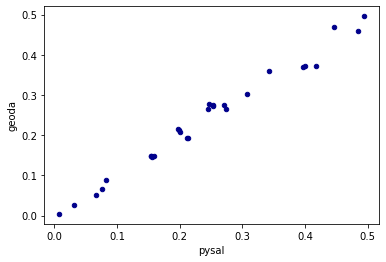

In [45]:
# Assess correlation between p-values
corrdf = pd.DataFrame(LJC_BV_Case1_v2.p_sim, commpop.PP_VAL_BV_C1).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

In [46]:
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):")
results = LJC_BV_Case1_v2.LJC == commpop['JC_BV_C1']
print(results.value_counts())

Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):
True    77
Name: JC_BV_C1, dtype: int64


### Case 2

In [47]:
test_results_case2_v2 = Local_Join_Count_BV(connectivity=balt_knn5).fit(x_balt, z_balt, case="CLC")

In [48]:
%timeit Local_Join_Count_BV(connectivity=balt_knn5).fit(x_balt, z_balt, case="CLC")

14.1 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
((60.7 - 28.3)/60.7)*100

53.377265238879744

53% increase in speed!

The correlation between the two sets of p-values is 0.9989891475400826


<AxesSubplot:xlabel='pysal', ylabel='geoda'>

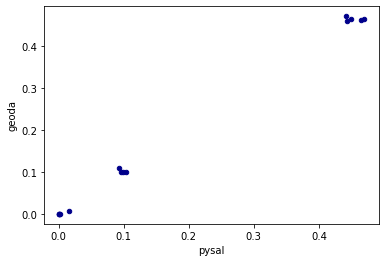

In [50]:
# Assess correlation between p-values
corrdf = pd.DataFrame(test_results_case2_v2.p_sim, GeoDa_LJC.PP_VAL_C2).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

In [51]:
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 2):")
results = test_results_case2_v2.LJC == GeoDa_LJC['JC_C2']
print(results.value_counts())

Comparison of GeoDa bivariate LJC to PySAL implementation (Case 2):
True    211
Name: JC_C2, dtype: int64
